In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

______________________________

In [ ]:
network = 'tarbase'
target_homology = 'mixed'

remove_SSD_pre_2R = True
keep_SSD_pre_2R = False

if remove_SSD_pre_2R and keep_SSD_pre_2R:
	raise ValueError("Cannot both remove and keep pre-2R SSD pairs. Choose one option or remove both.")

if remove_SSD_pre_2R:
	s = 'post_2R'
elif keep_SSD_pre_2R:
	s = 'pre_2R'
else:
	s = ''

In [151]:
if target_homology == 'wgd':
	file_path_1 = f'./output/{network}_om.z_1000.tsv'
	file_path_2 = f'./output/{network}_pm_mixed.z_1000.tsv'
elif target_homology == 'ssd':
	file_path_1 = f'./output/{network}_om_mixed.z_1000.tsv'
	file_path_2 = f'./output/{network}_pm.z_1000.tsv'
elif target_homology == 'mix':
	file_path_1 = f'./output/{network}_om.z_1000.tsv'
	file_path_2 = f'./output/{network}_pm.z_1000.tsv'
else:
	raise ValueError("target_homology must be either 'wgd', 'ssd' or 'mix'")

df_1 = pd.read_csv(file_path_1, sep='\t', header=0)
df_2 = pd.read_csv(file_path_2, sep='\t', header=0)

In [152]:
mirna_origin_file_path = '../../MirGeneDB_miRNA_origin/hsa_mirgenedb3.0_to_everything.mirna_origin.tsv'
df_mirna_origin = pd.read_csv(mirna_origin_file_path, sep='\t', header=None)
# keep only columns 8,14,15 and remove duplicates
df_mirna_origin = df_mirna_origin[[8, 14, 15]]
df_mirna_origin = df_mirna_origin.drop_duplicates()
cols = ["miRNA", "locus_node_of_origin", "family_node_of_origin"]
df_mirna_origin.columns = cols
df_mirna_origin

mirna_lno_dict = {}
for index, row in df_mirna_origin.iterrows():
	mirna = row['miRNA']
	lno = row['family_node_of_origin']
	if mirna not in mirna_lno_dict:
		mirna_lno_dict[mirna] = []
	mirna_lno_dict[mirna].append(lno)

In [153]:
ordered_lca = {
	'Eumetazoa': 0,
	'Bilateria': 1,
	'Nephrozoa': 2,
	'Chordata': 3,
	'Olfactores': 4,
	'Vertebrata': 5,
	'Gnathostomata': 6,
	'Osteichthyes': 7,
	'Euteleostomi': 8,
	'Sarcopterygii': 9,
	'Tetrapoda': 10,
	'Amniota': 11,
	'Mammalia': 12,
	'Theria': 13,
	'Eutheria': 14,
	'Boroeutheria': 15,
	'Euarchontoglires': 16,
	'Primates': 17,
	'Simiiformes': 18,
	'Catarrhini': 19,
	'Hominidae': 20,
	'H. sapiens': 21
}

reverted_ordered_lca = {v: k for k, v in ordered_lca.items()}

In [154]:
def add_lca(df):
    def compute_max_lca(miRNA):
        # If the miRNA value itself is NaN/null, skip immediately
        if pd.isna(miRNA):
            return -1
        # Look up its list of lno’s; if that’s not a list/tuple, treat as empty
        lno_list = mirna_lno_dict.get(miRNA, [])
        if not isinstance(lno_list, (list, tuple)):
            return -1
        # Map to ordered_lca values and take the max (or -1 if empty)
        return max((ordered_lca.get(lno, -1) for lno in lno_list), default=-1)

    # Compute temporary numeric LCA codes
    df['lca_1'] = df['miRNA_1'].apply(compute_max_lca)
    df['lca_2'] = df['miRNA_2'].apply(compute_max_lca)
    # Take the row-wise max
    df['lca_code'] = df[['lca_1', 'lca_2']].max(axis=1)
    df = df.drop(columns=['lca_1', 'lca_2'])
    # Map back to the label (or “Unknown”)
    df['lca'] = df['lca_code'].apply(
        lambda code: reverted_ordered_lca.get(code, 'Unknown')
    )
    return df

In [ ]:
df_wgd = df_1
df_ssd = df_2

df_wgd_lca = add_lca(df_wgd)
df_ssd_lca = add_lca(df_ssd)

In [158]:
print("Number of WGD pairs: ", len(df_wgd_lca))
print("Number of SSD pairs: ", len(df_ssd_lca))

Number of WGD pairs:  113
Number of SSD pairs:  1383


In [159]:
pre_2R_clades = ['Bilateria', 'Chordata', 'Eumetazoa', 'Vertebrata', 'Nephrozoa', 'Olphactores']

def all_clades_in_pre2R(mirna):
    clades = mirna_lno_dict.get(mirna, [])
    return all(clade in pre_2R_clades for clade in clades)

if remove_SSD_pre_2R:
	df_ssd_lca = df_ssd_lca[~(df_ssd_lca["miRNA_1"].apply(all_clades_in_pre2R) & df_ssd_lca["miRNA_2"].apply(all_clades_in_pre2R))]
      
if keep_SSD_pre_2R:
	df_ssd_lca = df_ssd_lca[df_ssd_lca["miRNA_1"].apply(all_clades_in_pre2R) | df_ssd_lca["miRNA_2"].apply(all_clades_in_pre2R)]

print("Number of WGD pairs: ", len(df_wgd_lca))
print("Number of SSD pairs: ", len(df_ssd_lca))

Number of WGD pairs:  113
Number of SSD pairs:  417


In [ ]:
def remove_mirna_pairs(df1, df2):
	"""
	Removes from df1 all rows whose (miRNA_1, miRNA_2) pairs (regardless of order)
	are present in df2.
	"""
	# Create a set of tuples for the miRNA pairs in df2
	mirna_pairs = set()
	for _, row in df2.iterrows():
		mirna1 = row['miRNA_1']
		mirna2 = row['miRNA_2']
		if mirna1 != mirna2:
			mirna_pairs.add(tuple(sorted([mirna1, mirna2])))

	# Filter df1 to remove rows with miRNA pairs present in df2
	filtered_df = df1[~df1.apply(lambda row: tuple(sorted([row['miRNA_1'], row['miRNA_2']])) in mirna_pairs, axis=1)]
	
	return filtered_df

df_ssd_lca = remove_mirna_pairs(df_ssd_lca, df_wgd_lca)

In [161]:
print("Number of WGD pairs after removing miRNA pairs: ", len(df_wgd_lca))
print("Number of SSD pairs after removing miRNA pairs: ", len(df_ssd_lca))

Number of WGD pairs after removing miRNA pairs:  113
Number of SSD pairs after removing miRNA pairs:  402


In [162]:
# if the column Z-score is equal to "sigma_err" and the column "n_relevant_bifan" is equal to 0, then the Z-score is equal to 0
def remove_sigma_err(df):
    # Step 1: Set Z-score to 0 if Z-score == 'sigma_err' and n_relevant_bifan == 0
    mask_fix = (df['Z-score'] == 'sigma_err') & (df['n_relevant_bifan'] == 0)
    df.loc[mask_fix, 'Z-score'] = 0

    # Step 2: Remove rows where Z-score == 'sigma_err' and n_relevant_bifan != 0
    mask_remove = (df['Z-score'] == 'sigma_err') & (df['n_relevant_bifan'] != 0)
    df = df[~mask_remove]

    return df

df_wgd_lca = remove_sigma_err(df_wgd_lca)
df_ssd_lca = remove_sigma_err(df_ssd_lca)

In [ ]:
df_wgd_lca_zscores = df_wgd_lca['Z-score'].astype(float)
df_ssd_lca_zscores = df_ssd_lca['Z-score'].astype(float)

df_wgd_lca_nbifan = df_wgd_lca['n_relevant_bifan'].astype(int)
df_ssd_lca_nbifan = df_ssd_lca['n_relevant_bifan'].astype(int)

In [165]:
n_wgd = len(df_wgd_lca_zscores)
n_ssd = len(df_ssd_lca_zscores)

print("n_wgd in the boxplot: ", n_wgd)
print("n_ssd in the boxplot: ", n_ssd)

n_wgd in the boxplot:  113
n_ssd in the boxplot:  416


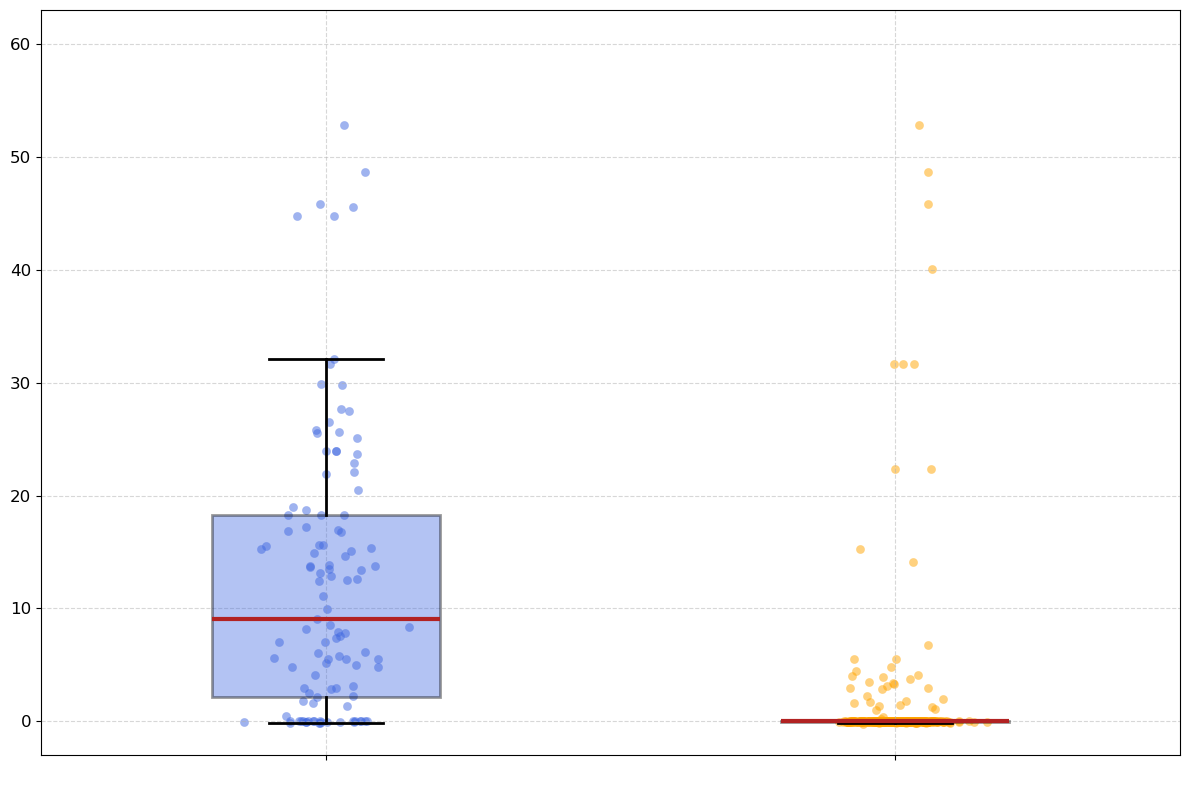

In [166]:
data = [df_wgd_lca_zscores, df_ssd_lca_zscores]
positions = [0, 1]
colors = ['royalblue', 'orange']

plt.figure(figsize=(12, 8))

box = plt.boxplot(data, 
                  positions=positions, 
                  widths=0.4,
                  patch_artist=True, 
                  showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)
    patch.set_alpha(0.4)
    
for element in ['whiskers', 'caps']:
    for line in box[element]:
        line.set_linewidth(2)
        line.set_color('black')
        
for element in ['medians']:
    for line in box[element]:
        line.set_linewidth(3)
        line.set_color('firebrick')

for i, (scores, color) in enumerate(zip(data, colors)):
    jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(scores))
    plt.scatter(jittered_x, scores, alpha=0.5, color=color, linewidth=0.2, label=['', ''][i])

plt.xticks(positions, [' ', ' '], fontsize=100)
plt.ylim(-3, 63)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig(f'../../local/pictures/{network}_{target_homology}_bifan_boxplot_zscores_mgdbSSD_{s}.png', dpi=300)
plt.show()

In [167]:
ks_stat, ks_p_value = stats.ks_2samp(df_wgd_lca_zscores, df_ssd_lca_zscores)
print(f"KS statistic: {ks_stat}, p-value: {ks_p_value}")

KS statistic: 0.6986683117767188, p-value: 1.0402109464113464e-42


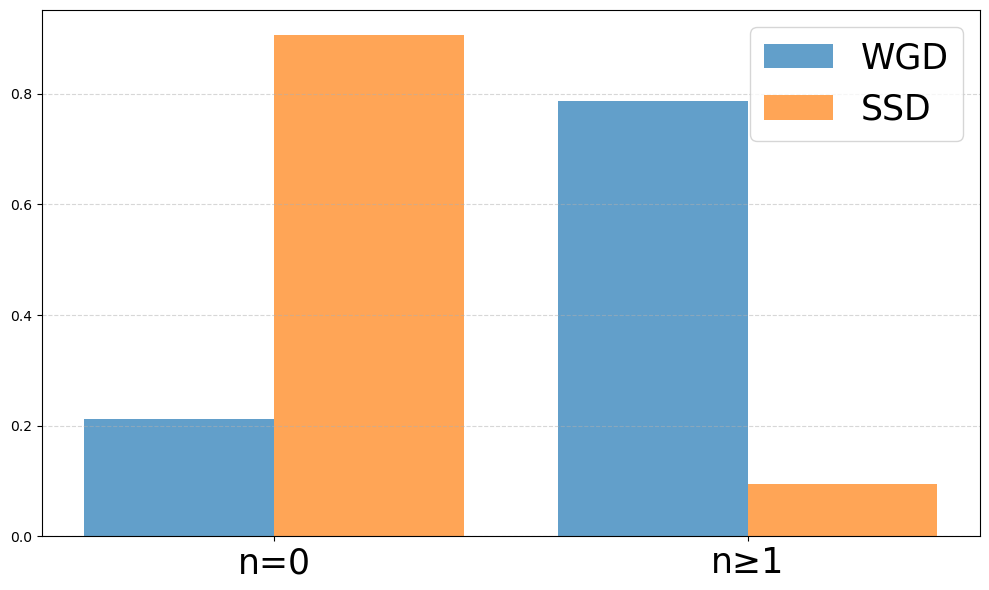

In [168]:
labels = ['n=0', 'n≥1']

def bin_bifans(count):
    if count == 0:
        return labels[0]
    else:
        return labels[1]

# Bin the counts
wgd_binned = pd.Series(df_wgd_lca_nbifan).apply(bin_bifans)
ssd_binned = pd.Series(df_ssd_lca_nbifan).apply(bin_bifans)

# Get relative frequencies for each bin
wgd_freq = wgd_binned.value_counts(normalize=True).reindex(labels, fill_value=0)
ssd_freq = ssd_binned.value_counts(normalize=True).reindex(labels, fill_value=0)

x = np.arange(len(labels))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, wgd_freq, width=width, label='WGD', alpha=0.7)
plt.bar(x + width/2, ssd_freq, width=width, label='SSD', alpha=0.7)

plt.xticks(x, labels, fontsize=25)
plt.xlabel('')
plt.title('')
plt.legend(fontsize=25)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(f'../../local/pictures/{network}_{target_homology}_bifan_barplot_zscores_mgdbSSD.png', dpi=300)
plt.show()